In [1]:
import torch

sintelPerFlow = torch.load("dataLog/sintelPerFlow_final.pth")
moviPerFlow = torch.load("dataLog/moviPerFlow_final.pth")

### 从movi中sintel找出最接近的50张样本

In [2]:
analyseDataset = moviPerFlow
velocityQuantile = torch.tensor([list(x[0]) for x in analyseDataset])
velocityStd = torch.tensor([list(x[1]) for x in analyseDataset])
directDistribute = torch.tensor([list(x[2]) for x in analyseDataset])
directStd = torch.tensor([list(x[3]) for x in analyseDataset])

In [3]:
baseDataset = sintelPerFlow
basevelocityQuantile = torch.tensor([list(x[0]) for x in baseDataset])
basevelocityStd = torch.tensor([list(x[1]) for x in baseDataset])
basedirectDistribute = torch.tensor([list(x[2]) for x in baseDataset])
basedirectStd = torch.tensor([list(x[3]) for x in baseDataset])

### 计算每两张图片之间的相似度

In [7]:
def getSimilarityMat(vQ, baseVQ):
    assert baseVQ.shape[1] == vQ.shape[1]
    vectorLen = baseVQ.shape[1]
    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)

    broadBaseVQ = torch.zeros((baseVQ.shape[0], vQ.shape[0], vectorLen))
    broadVQ = torch.zeros((baseVQ.shape[0], vQ.shape[0], vectorLen))

    broadVQ += vQ.reshape((1, vQ.shape[0], vectorLen))
    broadBaseVQ += baseVQ.reshape((baseVQ.shape[0], 1, vectorLen))

    similarMat = cos(broadVQ, broadBaseVQ)
    return similarMat


velocityQuantile *= torch.tensor([[8, 4, 2, 1 / 2]])
basevelocityQuantile *= torch.tensor([[8, 4, 2, 1 / 2]])
vQSimilarMat = getSimilarityMat(velocityQuantile, basevelocityQuantile)
vSSimilarMat = getSimilarityMat(velocityStd, basevelocityStd)
dDSimilarMat = getSimilarityMat(directDistribute, basedirectDistribute)
dSSimilarMat = getSimilarityMat(directStd, basedirectStd)

### 通过topk 50找到flattenIdx

In [8]:
sumSimilarMat = vQSimilarMat + vSSimilarMat + dDSimilarMat + dSSimilarMat

In [37]:
values, indices = sumSimilarMat.topk(50, dim=1)
flattenIdx = indices.reshape(-1)
uniqueIdx = flattenIdx.unique()

In [39]:
torch.save(uniqueIdx, "filterMoviIndex.pth")

### 以下为相似图像的可视化

In [25]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
import numpy as np


def drawConcat_v1(dataTuple):
    images, flow, valid = dataTuple[0], dataTuple[1], dataTuple[2]
    images, flow = np.uint8(images.permute((0, 2, 3, 1))), np.float32(
        flow.permute((1, 2, 0))
    )

    def renderFlowImg(flow, *, maxFlow=-1, style="mpi"):
        MVX_PLANE = 0
        MVY_PLANE = 1
        assert style in ["kitti-c++", "mpi"], "unknown flow rendering style: {}".format(
            style
        )
        assert len(flow.shape) == 3
        mvx = flow[:, :, MVX_PLANE]
        mvy = flow[:, :, MVY_PLANE]
        magnitude = np.sqrt(mvx**2 + mvy**2)
        direction = np.arctan2(mvy, mvx)
        if maxFlow < 0:
            if style == "kitti-c++":
                maxFlow = np.fmax(magnitude.max(), 1.0)
            else:
                # mpi style
                maxFlow = 1.2 * max(np.fabs(mvx).max(), np.fabs(mvy).max())
                maxFlow = np.fmax(maxFlow, 1.0)
            print("maxFlow = {:.1f}".format(maxFlow))
        h = np.fmod(direction / (2 * np.pi) + 1.0, 1.0) * 360
        assert h.min() >= 0
        if style == "kitti-c++":
            """KITTI C++ hsv2rgb has bug. Here tries to mimic the final result"""
            s = np.clip(magnitude * 300 / maxFlow, 0, 1.0)
            v = np.clip(magnitude * 8 / maxFlow, 0, 1.0)
        else:
            # mpi style
            n = 8
            s = np.clip(magnitude * n / maxFlow, 0, 1.0)
            v = np.clip(n - s, 0, 1.0)
        img = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2RGB)
        #     img[~valid] = 0
        #     return np.uint8(img * 255)[:,:,[1,2,0]]
        return np.uint8(img * 255)

    nrow, ncol = 1, 3
    fig = plt.figure(figsize=(ncol * 5, nrow * 5))

    gs = gridspec.GridSpec(
        nrow,
        ncol,
        wspace=0.0,
        hspace=0.0,
        top=(1.0 - 0.5 / (nrow + 1)) * 5,
        bottom=5 * (0.5 / (nrow + 1)),
        left=(0.5 / (ncol + 1)),
        right=(1 - 0.5 / (ncol + 1)),
    )

    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[0, 2])

    ax0.imshow(images[0])
    ax0.axis("off")
    ax1.imshow(images[1])
    ax1.axis("off")
    ax2.imshow(renderFlowImg(flow))
    ax2.axis("off")
    plt.show()

### 读取数据集

In [27]:
import sys
sys.path.append("core")
import datasets
sintel_dataset = datasets.MpiSintel(None, split='training', dstype='clean') + datasets.MpiSintel(None, split='training', dstype='final')
movi_dataset = datasets.moviSubset()

maxFlow = 32.2


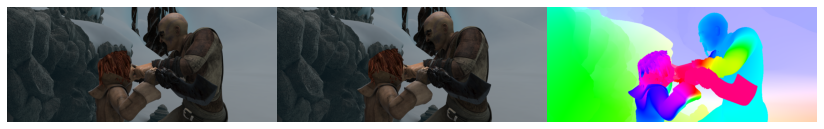

maxFlow = 19.7


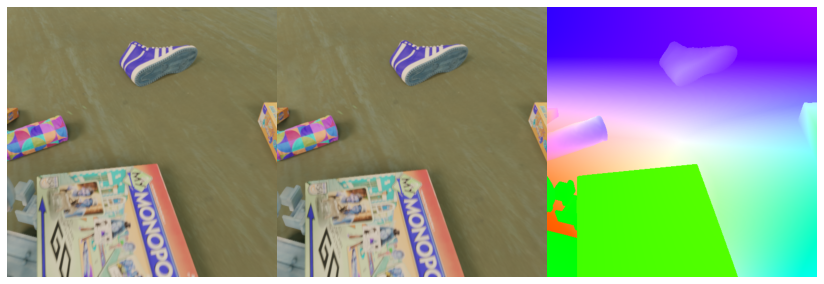

maxFlow = 18.1


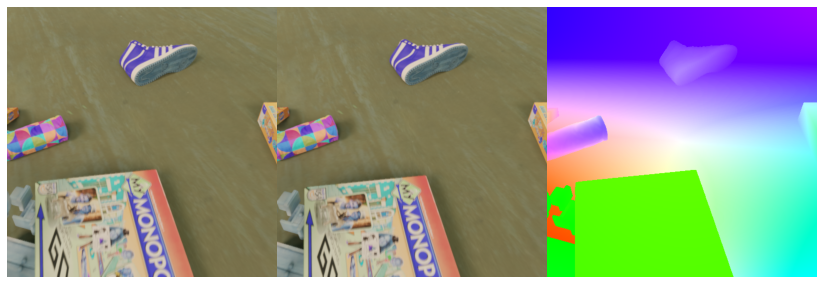

maxFlow = 16.3


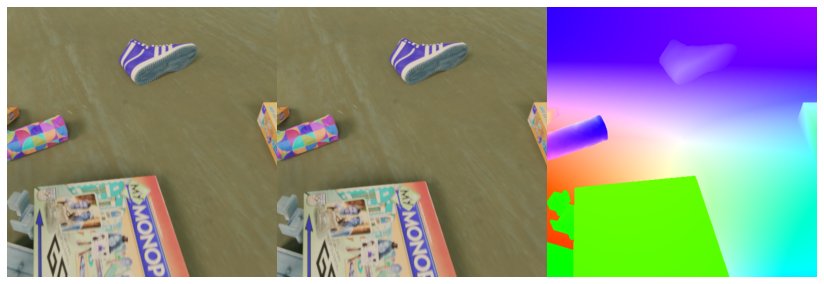

In [34]:
visualIdx = 2
drawConcat_v1(sintel_dataset[visualIdx])
drawConcat_v1(movi_dataset[indices[visualIdx][0]])
drawConcat_v1(movi_dataset[indices[visualIdx][1]])
drawConcat_v1(movi_dataset[indices[visualIdx][2]])